In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import seaborn as sns

## List of teams

In [2]:
teams = [
    "India", "Australia", "England", "South Africa", "Pakistan",
    "New Zealand", "West Indies", "Afghanistan", "Sri Lanka",
    "Ireland", "Netherlands", "Zimbabwe", "Namibia", "Scotland", "UAE",
    "Nepal", "USA", "Canada", "Oman", "Italy"
]

## Ratings of teams as on 09/02/2026

In [3]:
ratings = {
    "India": 273,
    "Australia": 261,
    "England": 259,
    "South Africa": 241,
    "Pakistan": 238,
    "New Zealand": 251,
    "West Indies": 235,
    "Afghanistan": 221,
    "Sri Lanka": 228,
    "Ireland": 200,
    "Netherlands": 182,
    "Zimbabwe": 200,
    "Namibia": 181,
    "Scotland": 182,
    "UAE": 176,
    "Nepal": 176,
    "USA": 175,
    "Canada": 154,
    "Oman": 152,
    "Italy": 118
}

## Using ELO system ratings to calculate winning probability

In [4]:
def win_probability(rating_a, rating_b, scale=100):
    return 1 / (1 + 10 ** ((rating_b - rating_a) / scale))

## Generating winnning probability table

### The probabilities are for teams listed on index of the table against the teams in the columns

In [5]:
prob_matrix = pd.DataFrame(index=teams, columns=teams, dtype=float)

for team_a in teams:
    for team_b in teams:
        if team_a == team_b:
            prob_matrix.loc[team_a, team_b] = 0.0
        else:
            prob_matrix.loc[team_a, team_b] = win_probability(
                ratings[team_a], ratings[team_b]
            )
            
prob_matrix.style.format("{:.2%}")

,India,Australia,England,South Africa,Pakistan,New Zealand,West Indies,Afghanistan,Sri Lanka,Ireland,Netherlands,Zimbabwe,Namibia,Scotland,UAE,Nepal,USA,Canada,Oman,Italy
India,0.00%,56.86%,57.99%,67.63%,69.12%,62.40%,70.58%,76.81%,73.81%,84.30%,89.05%,84.30%,89.27%,89.05%,90.32%,90.32%,90.52%,93.94%,94.19%,97.26%
Australia,43.14%,0.00%,51.15%,61.31%,62.94%,55.73%,64.54%,71.53%,68.13%,80.29%,86.05%,80.29%,86.32%,86.05%,87.62%,87.62%,87.87%,92.16%,92.48%,96.42%
England,42.01%,48.85%,0.00%,60.22%,61.86%,54.59%,63.47%,70.58%,67.12%,79.55%,85.48%,79.55%,85.77%,85.48%,87.11%,87.11%,87.37%,91.82%,92.16%,96.26%
South Africa,32.37%,38.69%,39.78%,0.00%,51.73%,44.27%,53.45%,61.31%,57.43%,71.99%,79.55%,71.99%,79.92%,79.55%,81.71%,81.71%,82.05%,88.11%,88.59%,94.44%
Pakistan,30.88%,37.06%,38.14%,48.27%,0.00%,42.57%,51.73%,59.66%,55.73%,70.58%,78.41%,70.58%,78.79%,78.41%,80.65%,80.65%,81.01%,87.37%,87.87%,94.06%
New Zealand,37.60%,44.27%,45.41%,55.73%,57.43%,0.00%,59.11%,66.61%,62.94%,76.39%,83.04%,76.39%,83.37%,83.04%,84.90%,84.90%,85.19%,90.32%,90.72%,95.53%
West Indies,29.42%,35.46%,36.53%,46.55%,48.27%,40.89%,0.00%,57.99%,54.02%,69.12%,77.21%,69.12%,77.62%,77.21%,79.55%,79.55%,79.92%,86.59%,87.11%,93.67%
Afghanistan,23.19%,28.47%,29.42%,38.69%,40.34%,33.39%,42.01%,0.00%,45.98%,61.86%,71.05%,61.86%,71.53%,71.05%,73.81%,73.81%,74.25%,82.39%,83.04%,91.46%
Sri Lanka,26.19%,31.87%,32.88%,42.57%,44.27%,37.06%,45.98%,54.02%,0.00%,65.58%,74.25%,65.58%,74.69%,74.25%,76.81%,76.81%,77.21%,84.60%,85.19%,92.64%
Ireland,15.70%,19.71%,20.45%,28.01%,29.42%,23.61%,30.88%,38.14%,34.42%,0.00%,60.22%,50.00%,60.77%,60.22%,63.47%,63.47%,64.01%,74.25%,75.12%,86.85%


### Function to simulate match between teams

In [6]:
def simulate_match(team_a, team_b):
    p = prob_matrix.loc[team_a, team_b]
    return team_a if random.random() < p else team_b

### Functions to simulate matches in group and to assign points

In [7]:
def simulate_match_in_group(team_a, team_b, group):
    p = prob_matrix.loc[team_a, team_b]
    if random.random() < p:
        group.loc[team_a, "Points"] += 1
    else:
        group.loc[team_b, "Points"] += 1

### Function to simulate matches in the group stage

In [8]:
def simulate_group_stage(groupstage):
    for group in groupstage:
        team_list = list(group.index)
        for i in range(len(team_list)):
            for j in range(i+1,len(team_list)):
                simulate_match_in_group(team_list[i], team_list[j], group)

### Function to assign teams to group of Super 8

In [15]:
def assigning_super8(groupstage, super8):
    newIndex1 = []
    newIndex2 = []
    for group in groupstage:
        group.sort_values(by="Points", ascending=False, inplace=True)
        newIndex1.append(list(group["Points"].index)[0])
        newIndex2.append(list(group["Points"].index)[1])
    super8[0].index = newIndex1
    super8[1].index = newIndex2

### Function to simulate matches in Super 8 group

In [10]:
def simulate_super8(super8):
    for group in super8:
        team_list = list(group.index)
        for i in range(len(team_list)):
            for j in range(i+1,len(team_list)):
                simulate_match_in_group(team_list[i], team_list[j], group)

### Function to assign semifinalist

In [11]:
def assigning_semifinalist(super8):
    newIndex = []
    for group in super8:
        group.sort_values(by="Points", ascending=False, inplace=True)
        newIndex.append(list(group["Points"].index)[0])
        newIndex.append(list(group["Points"].index)[1])
    return newIndex

### Fnnction to simulate semifinal and final

In [12]:
def simulate_final(semifinalist):
    finalist1 = simulate_match(semifinalist[0],semifinalist[3])
    finalist2 = simulate_match(semifinalist[1],semifinalist[2])
    winner = simulate_match(finalist1, finalist2)
    return winner

### Main function to execute monte carlo simulate 

In [16]:
def simulate_montecarlo(iterations):

    winner_list = pd.DataFrame({"Wins":[0 for i in range(20)]}, index=teams)
    groupA = ["India", "Pakistan", "USA", "Netherlands", "Namibia"]
    groupB = ["Australia", "Sri Lanka", "Ireland", "Zimbabwe", "Oman"]
    groupC = ["England", "West Indies", "Scotland", "Nepal", "Italy"]
    groupD = ["New Zealand", "South Africa", "Afghanistan", "Canada", "UAE"]
    for i in tqdm(range(iterations), desc="Iterating"):
        groupAstanding = pd.DataFrame({"Points":[0,0,0,0,0]}, index=groupA)
        groupBstanding = pd.DataFrame({"Points":[0,0,0,0,0]}, index=groupB)
        groupCstanding = pd.DataFrame({"Points":[0,0,0,0,0]}, index=groupC)
        groupDstanding = pd.DataFrame({"Points":[0,0,0,0,0]}, index=groupD)
        group1standing = pd.DataFrame({"Points":[0,0,0,0]})
        group2standing = pd.DataFrame({"Points":[0,0,0,0]})
        groupstage = [groupAstanding, groupBstanding, groupCstanding, groupDstanding]
        super8 = [group1standing, group2standing]
        
        simulate_group_stage(groupstage)
        assigning_super8(groupstage, super8)
        simulate_super8(super8)
        assigning_semifinalist(super8)
        winner = simulate_final(assigning_semifinalist(super8))
        winner_list.loc[winner, "Wins"] += 1
        
    return winner_list

### Simulating the tournament for 10000 times

In [17]:
result = simulate_montecarlo(10000)

Iterating:   0%|          | 0/10000 [00:00<?, ?it/s]

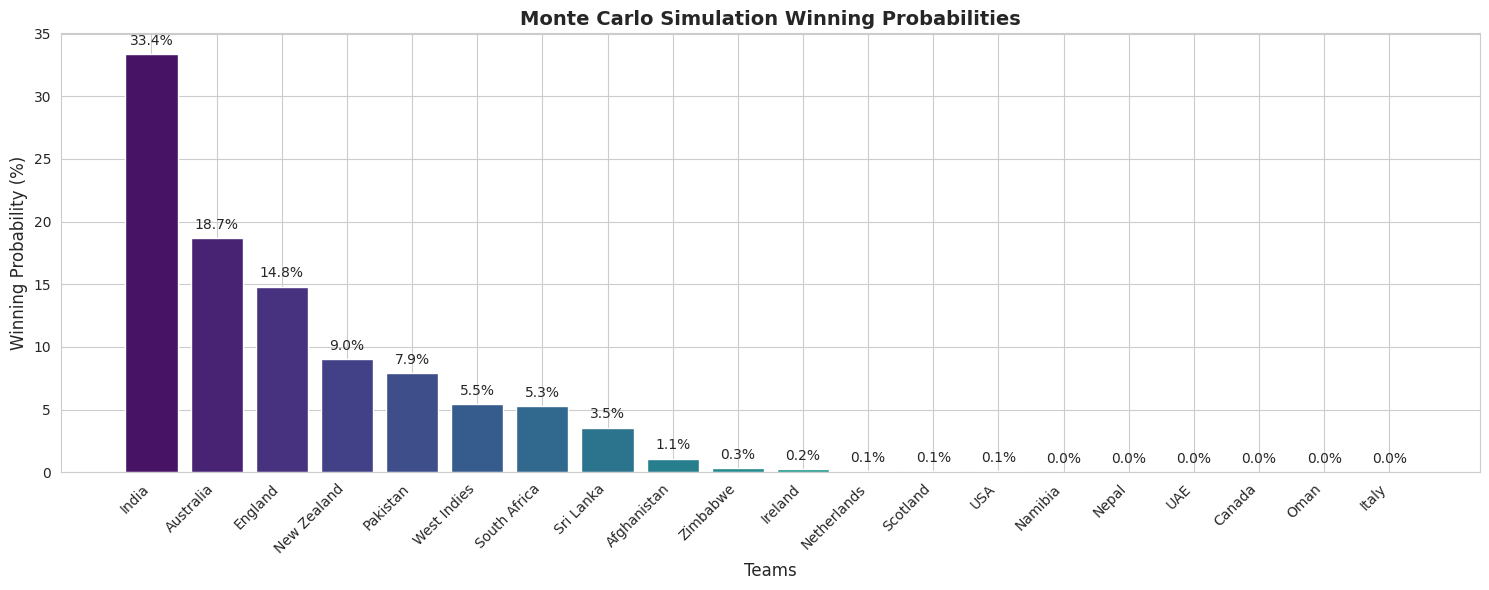

In [ ]:
result['percentage'] = result['Wins'] / result['Wins'].sum() * 100
result = result.sort_values('percentage', ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(15, 6))

bars = plt.bar(result.index, result['percentage'], 
               color=sns.color_palette("viridis", len(result)))

plt.ylabel("Winning Probability (%)", fontsize=12)
plt.xlabel("Teams", fontsize=12)
plt.title("Monte Carlo Simulation Winning Probabilities", fontsize=14, weight='bold')

plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.5,
             f'{height:.1f}%',
             ha='center',
             va='bottom',
             fontsize=10)

plt.tight_layout()
plt.show()
